# RNN Classifier

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from itertools import chain
import sys
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import rnn

In [4]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device("cpu") # RNN training way faster on CPU
print(f"Using {device} device")

Using cpu device


### Data Preperation

In [5]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]
batch_size = 1
min_length = None
max_length = None
padding_pos = "right" if batch_size > 1 else None

train_dataset = mlh.CodonDataset(organism=organism, split="train", min_length=min_length, max_length=max_length, padding_pos=padding_pos)
print("Ausgewählter Organismus:", organism)
print("Anzahl Trainingsdaten:", len(train_dataset))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=4)
valid_dataset = mlh.CodonDataset(organism=organism, split="valid", min_length=min_length, max_length=max_length, padding_pos=padding_pos)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

Ausgewählter Organismus: E.Coli
Anzahl Trainingsdaten: 3085


### Hyperparameters and Model Initialization

In [5]:
# Model
input_dim = len(mlh.amino_acids)
output_dim = len(mlh.codons)
n_hidden = 128 # number of hidden layers

rnnModel = rnn.RNN(input_size=input_dim, hidden_size=n_hidden, output_size=output_dim, batch_size=batch_size)
print(rnnModel)

RNN(
  (i2h): Linear(in_features=22, out_features=128, bias=False)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=65, bias=True)
)


### Training

In [6]:
# Train variables
epochs = 1
learning_rate = 0.001
loss = nn.CrossEntropyLoss()

# optimizer = optim.Adagrad(rnnModel.parameters(), lr=learning_rate)
# optimizer = optim.Adam(rnnModel.parameters(), lr=learning_rate)
# optimizer = optim.RMSprop(rnnModel.parameters(), lr=learning_rate)
optimizer = optim.SGD(rnnModel.parameters(), lr=learning_rate, momentum=0.9)

valid_every_epoch = 0.25 # validate after every quarter (0.25) of the data

In [7]:
tr_losses, tr_acc_per_epoch = rnn.train(rnnModel, data=train_loader, valid_loader=valid_loader,
                                        epochs=epochs, valid_every_epoch=valid_every_epoch,
                                        optimizer=optimizer, loss_fn=loss, device=device)

=> Starting training on device: cpu
loss:  3.7546  [  200/ 3085]
loss:  3.3553  [  400/ 3085]
loss:  2.9590  [  600/ 3085]
vacc:  0.5124
loss:  2.6176  [  800/ 3085]
loss:  2.3568  [ 1000/ 3085]
loss:  2.1628  [ 1200/ 3085]
loss:  2.0177  [ 1400/ 3085]
vacc:  0.5188
loss:  1.9061  [ 1600/ 3085]
loss:  1.8143  [ 1800/ 3085]
loss:  1.7407  [ 2000/ 3085]
loss:  1.6803  [ 2200/ 3085]
vacc:  0.5196
loss:  1.6293  [ 2400/ 3085]
loss:  1.5856  [ 2600/ 3085]
loss:  1.5483  [ 2800/ 3085]
loss:  1.5156  [ 3000/ 3085]
vacc:  0.5207
=> epoch: 1/1, loss: 1.5030, epoch time: 164.25s
=> Finished training in 164.25s


In [42]:
tr_losses_flat = [l for l in tr_losses.values()]
tr_losses_flat = list(chain.from_iterable(tr_losses_flat))
tr_acc_per_epoch_flat = [l for l in tr_acc_per_epoch.values()]
tr_acc_per_epoch_flat = list(chain.from_iterable(tr_acc_per_epoch_flat))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0, 20.25, 20.5, 20.75, 21.0, 21.25, 21.5, 21.75, 22.0, 22.25, 22.5, 22.75, 23.0, 23.25, 23.5, 23.75, 24.0, 24.25, 24.5, 24.75, 25.0, 25.25, 25.5, 25.75, 26.0, 26.25, 26.5, 26.75, 27.0, 27.25, 27.5, 27.75, 28.0, 28.25, 28.5, 28.75, 29.0, 29.25, 29.5, 29.75, 30.0, 30.25, 30.5, 30.75, 31.0, 31.25, 31.5, 31.75, 32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, 33.75, 34.0, 34.25, 34.5, 34.75, 35.0, 35.25, 35.5, 35.75, 36.0, 36.25, 36.5, 36.75, 37.0, 37.25, 37.5, 37.75, 38.0, 38.25, 38.5, 38.75, 39.0, 39.25, 39.5, 39.75, 40.0

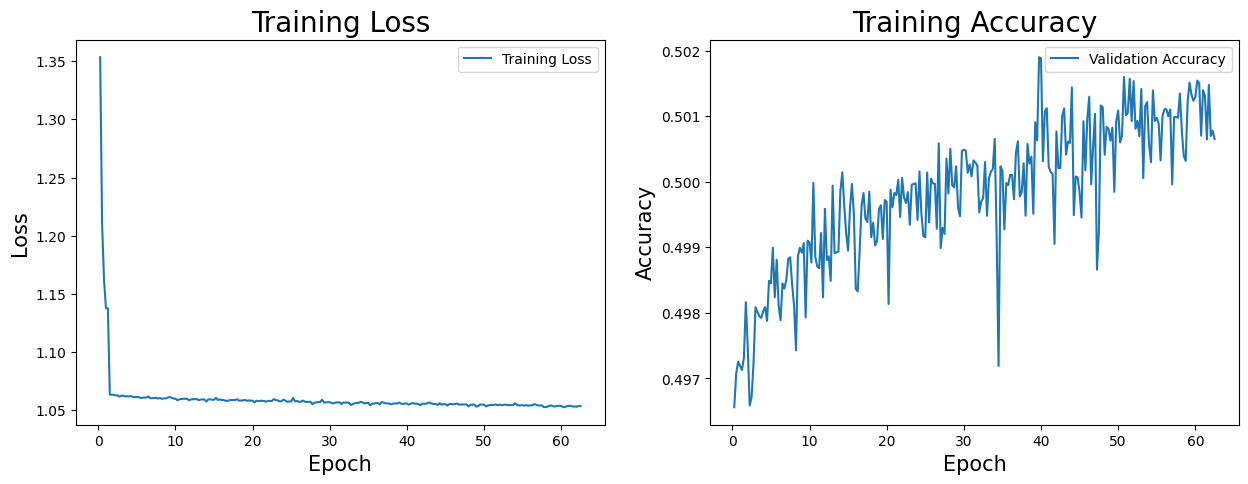

In [43]:
plt = mle.plot_training(tr_losses_flat, valid_accs=tr_acc_per_epoch_flat, part_of_epoch=valid_every_epoch)

In [ ]:
mlh.save_model(rnnModel, "rnn", organism, appendix=f"hidden{n_hidden}_epochs{epochs}_lr{learning_rate}_optim{optimizer.__class__.__name__}")

Model saved as 20240521150637_rnn_hidden128_epochs1_lr0.001_optimSGD.pt
